# ELUC Predictor
Trains an XGBoost model that can predict ELUC  
Looks for direct correlation at yearly level. Does NOT treat the data as a time series.

In [ ]:
# %pip install zarr
# %pip install regionmask
# %pip install xgboost
# %pip install scikit-learn

In [1]:
import numpy as np
import pandas as pd
import regionmask
import xarray as xr
import matplotlib.pyplot as plt

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [2]:
ds = xr.open_zarr("../data/gcb/processed/merged_aggregated_dataset_1850_2022.zarr.zip", consolidated=True)

# Data prep
## Align ELUC and Land Use data
According to the [ELUC Data Exploration](../data/gcb/ELUC_data_exploration.ipynb) notebook ELUC is off by one year when compared to the change in land use. This is probably because land use data is a snapshot at the begining of the year. So ELUC of 2015 is caused by the change that has been observed on Jan 1 2016. 

In [3]:
# Move ELUC forward by 1 year
# ds['ELUC'] = ds['ELUC'].roll(time=1, roll_coords=False)
# ds['ELUC_diff'] = ds['ELUC_diff'].roll(time=1, roll_coords=False)
ds['ELUC'] = ds['ELUC'].shift(time=1)
ds['ELUC_diff'] = ds['ELUC_diff'].shift(time=1)

In [4]:
ds['time'] = ds.time - 1

## Add countries

In [5]:
ds = ds.stack(latlon=('lat', 'lon'))

In [6]:
regionmask.__version__

'0.9.0'

In [7]:
# Train on countries 0-80, and test on the rest, and test on the last 15 years of data
country_mask = regionmask.defined_regions.natural_earth_v5_0_0.countries_110.mask(ds)
ds = ds.assign_coords(country=country_mask)

In [8]:
ds

<xarray.Dataset>
Dimensions:         (time: 173, latlon: 966240)
Coordinates:
    mask            (latlon) float64 nan nan nan nan ... 159.0 159.0 159.0 159.0
  * time            (time) int32 1849 1850 1851 1852 ... 2018 2019 2020 2021
  * latlon          (latlon) object MultiIndex
  * lat             (latlon) float32 83.38 83.38 83.38 ... -89.88 -89.88 -89.88
  * lon             (latlon) float32 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
    country         (latlon) float64 nan nan nan nan ... 159.0 159.0 159.0 159.0
Data variables: (12/28)
    ELUC            (time, latlon) float32 dask.array<chunksize=(173, 1440), meta=np.ndarray>
    ELUC_diff       (time, latlon) float32 dask.array<chunksize=(173, 1440), meta=np.ndarray>
    c3ann           (time, latlon) float32 dask.array<chunksize=(173, 1440), meta=np.ndarray>
    c3ann_diff      (time, latlon) float32 dask.array<chunksize=(173, 1440), meta=np.ndarray>
    c3nfx           (time, latlon) float32 dask.array<chunksize=(173, 1440), meta=np.ndarray>
    c3nfx_diff      (time, latlon) float32 dask.array<chunksize=(173, 1440), meta=np.ndarray>
    ...              ...
    secdf           (time, latlon) float32 dask.array<chunksize=(173, 1440), meta=np.ndarray>
    secdf_diff      (time, latlon) float32 dask.array<chunksize=(173, 1440), meta=np.ndarray>
    secdn           (time, latlon) float32 dask.array<chunksize=(173, 1440), meta=np.ndarray>
    secdn_diff      (time, latlon) float32 dask.array<chunksize=(173, 1440), meta=np.ndarray>
    urban           (time, latlon) float32 dask.array<chunksize=(173, 1440), meta=np.ndarray>
    urban_diff      (time, latlon) float32 dask.array<chunksize=(173, 1440), meta=np.ndarray>

In [9]:
countries = regionmask.defined_regions.natural_earth_v5_0_0.countries_110
countries

<regionmask.Regions>
Name:     Natural Earth Countries: 110m
Source:   http://www.naturalearthdata.com
overlap:  False

Regions:
  0 FJ                     Fiji
  1 TZ                 Tanzania
  2 WS                W. Sahara
  3 CA                   Canada
  4 US United States of America
 .. ..                      ...
172 RS                   Serbia
173 ME               Montenegro
174 KO                   Kosovo
175 TT      Trinidad and Tobago
176 SS                 S. Sudan

[177 regions]

In [10]:
countries_df = countries.to_dataframe()
countries_df

,abbrevs,names
numbers,,
0,FJ,Fiji
1,TZ,Tanzania
2,WS,W. Sahara
3,CA,Canada
4,US,United States of America
...,...,...
172,RS,Serbia
173,ME,Montenegro
174,KO,Kosovo


In [11]:
ds.country

<xarray.DataArray 'country' (latlon: 966240)>
array([ nan,  nan,  nan, ..., 159., 159., 159.])
Coordinates:
    mask     (latlon) float64 nan nan nan nan nan ... 159.0 159.0 159.0 159.0
  * latlon   (latlon) object MultiIndex
  * lat      (latlon) float32 83.38 83.38 83.38 83.38 ... -89.88 -89.88 -89.88
  * lon      (latlon) float32 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
    country  (latlon) float64 nan nan nan nan nan ... 159.0 159.0 159.0 159.0

In [12]:
np.unique(ds.time)

array([1849, 1850, 1851, 1852, 1853, 1854, 1855, 1856, 1857, 1858, 1859,
       1860, 1861, 1862, 1863, 1864, 1865, 1866, 1867, 1868, 1869, 1870,
       1871, 1872, 1873, 1874, 1875, 1876, 1877, 1878, 1879, 1880, 1881,
       1882, 1883, 1884, 1885, 1886, 1887, 1888, 1889, 1890, 1891, 1892,
       1893, 1894, 1895, 1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903,
       1904, 1905, 1906, 1907, 1908, 1909, 1910, 1911, 1912, 1913, 1914,
       1915, 1916, 1917, 1918, 1919, 1920, 1921, 1922, 1923, 1924, 1925,
       1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936,
       1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947,
       1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958,
       1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969,
       1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980,
       1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991,
       1992, 1993, 1994, 1995, 1996, 1997, 1998, 19

## Remove NaN ELUC_diff

In [13]:
# Create a boolean mask based on NaN values for ELUC_diff
mask = ds['ELUC_diff'].isnull()

In [14]:
# Filter the dataset based on the mask
ds = ds.where(~mask, drop=True)

In [15]:
np.unique(ds.time)

array([1851, 1852, 1853, 1854, 1855, 1856, 1857, 1858, 1859, 1860, 1861,
       1862, 1863, 1864, 1865, 1866, 1867, 1868, 1869, 1870, 1871, 1872,
       1873, 1874, 1875, 1876, 1877, 1878, 1879, 1880, 1881, 1882, 1883,
       1884, 1885, 1886, 1887, 1888, 1889, 1890, 1891, 1892, 1893, 1894,
       1895, 1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904, 1905,
       1906, 1907, 1908, 1909, 1910, 1911, 1912, 1913, 1914, 1915, 1916,
       1917, 1918, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927,
       1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938,
       1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949,
       1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960,
       1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971,
       1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982,
       1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993,
       1994, 1995, 1996, 1997, 1998, 1999, 2000, 20

## Features
Do not use these columns as feature:
- ELUC
- ELUC_diff
- cell_area_diff

In [16]:
LAND_FEATURES = ['c3ann', 'c3nfx', 'c3per','c4ann', 'c4per',
 'pastr', 'primf', 'primn', 'range', 'secdf', 'secdn', 'urban', 'cell_area']

LAND_DIFF_FEATURES = ['c3ann_diff', 'c3nfx_diff', 'c3per_diff','c4ann_diff', 'c4per_diff',
 'pastr_diff', 'primf_diff', 'primn_diff', 'range_diff', 'secdf_diff', 'secdn_diff', 'urban_diff']

FEATURES = LAND_FEATURES + LAND_DIFF_FEATURES

LABEL = 'ELUC'

## Dataset prep

In [17]:
def convert_to_dataframe(da):
    df = da.to_dataframe()
    df.index = df.index.set_names(['time', 'i_lat', 'i_lon'])
    df = df.reset_index()
    return df

In [51]:
def create_country_dataset(ds, country_id_list, last_train_year):
    train_da = ds.where(ds.country.isin(country_id_list), drop=True).where(ds.time <= last_train_year, drop=True)
    test_da = ds.where(ds.country.isin(country_id_list),  drop=True).where(ds.time > last_train_year, drop=True)
    # Extract features and target variable from the training dataset
    X_train = train_da[FEATURES]
    y_train = train_da[LABEL]
    # Extract features and target variable from the test dataset
    X_test = test_da[FEATURES]
    y_test = test_da[LABEL]

    # Convert to Pandas dataframe
    X_train_df = convert_to_dataframe(X_train)
    y_train_df = convert_to_dataframe(y_train)
    X_test_df = convert_to_dataframe(X_test)
    y_test_df = convert_to_dataframe(y_test)
    
    return {"Train": {"X": X_train_df,
                      "y": y_train_df},
            "Test": {"X": X_test_df,
                      "y": y_test_df}}

In [19]:
def evaluate_predictor(predictor, dfs):
    features = dfs["Test"]["X"][FEATURES]
    labels = dfs["Test"]["y"][LABEL]
    # Predict
    preds = predictor.predict(features)
    # Compute errors
    mse = mean_squared_error(labels, preds, squared=True)
    rmse = mean_squared_error(labels, preds, squared=False)
    mae = mean_absolute_error(labels, preds)
    print(f"MSE: {mse}")
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")

In [20]:
def plot_feature_importance(predictor):
    feature_important = predictor.get_booster().get_score(importance_type='weight')
    keys = list(feature_important.keys())
    values = list(feature_important.values())

    feature_importance_df = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
    feature_importance_df.nlargest(40, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 40 features

In [21]:
def plot_luc(dfs, title):
    X_test_df = dfs["Test"]["X"]
    agg_df = X_test_df \
        .groupby(["time"])[LAND_DIFF_FEATURES] \
        .mean() \
        .sort_values(by=["time"]).reset_index()
    agg_df[["time"] + LAND_DIFF_FEATURES].plot(title=title, x='time')
    plt.legend(bbox_to_anchor=(1.0, 1.0))

In [22]:
def plot_eluc(predictor, dfs, title):
    features = dfs["Test"]["X"][FEATURES]
    label_pred = f"{LABEL}_Predicted"
    
    # Copy the dataframe
    eluc_df = dfs["Test"]["y"].copy()
    # Make predictions
    preds = predictor.predict(features)
    # Add predictions to the copied dataframe
    eluc_df[label_pred] = preds
    
    agg_eluc_df = eluc_df \
        .groupby(["time"])[[LABEL, label_pred]] \
        .mean() \
        .sort_values(by=["time"]).reset_index()
    
    agg_eluc_df.plot(x="time", y=[LABEL, label_pred], title=title)

# UK
## Train and test sets
Create a dataset for a single country to keep it small and easy to train on  
Country: United Kingdom  
Train on data between 1850 and 2007  
Test on data after 2007 (i.e. 2008 to 2021)

In [23]:
countries_df[countries_df.names == 'United Kingdom']

,abbrevs,names
numbers,,
143,GB,United Kingdom


In [52]:
uk_dfs = create_country_dataset(ds, [143], 2007)

In [53]:
uk_dfs["Test"]["y"].head()

,time,i_lat,i_lon,mask,lat,lon,country,ELUC
0,2008,58.625,-3.125,143.0,58.625,-3.125,143.0,-0.011683
1,2008,58.375,-5.125,143.0,58.375,-5.125,143.0,0.056483
2,2008,58.375,-4.875,143.0,58.375,-4.875,143.0,0.089952
3,2008,58.375,-4.625,143.0,58.375,-4.625,143.0,0.158279
4,2008,58.375,-4.375,143.0,58.375,-4.375,143.0,0.085307


## Check data

In [26]:
ireland_df = uk_dfs["Test"]["X"][(uk_dfs["Test"]["X"].i_lat==54.125) & 
                          (uk_dfs["Test"]["X"].i_lon==-6.875)]
ireland_df['ELUC'] = uk_dfs["Test"]["y"][(uk_dfs["Test"]["y"].i_lat==54.125) & 
                          (uk_dfs["Test"]["y"].i_lon==-6.875)]['ELUC']
ireland_df.head()

/var/folders/w6/w8ptt70j5ylfrcw1rgjc5pfr0000gq/T/ipykernel_71031/3857965749.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ireland_df['ELUC'] = uk_dfs["Test"]["y"][(uk_dfs["Test"]["y"].i_lat==54.125) &


,time,i_lat,i_lon,c3ann,c3nfx,c3per,c4ann,c4per,pastr,primf,...,primn_diff,range_diff,secdf_diff,secdn_diff,urban_diff,mask,lat,lon,country,ELUC
221,2008,54.125,-6.875,0.062291,0.0,0.0,0.0,0.0,0.726815,0.0,...,0.0,0.000000e+00,0.010210,0.0,0.000074,143.0,54.125,-6.875,143.0,-0.463282
723,2009,54.125,-6.875,0.058646,0.0,0.0,0.0,0.0,0.808217,0.0,...,0.0,0.000000e+00,-0.077815,0.0,0.000058,143.0,54.125,-6.875,143.0,0.642097
1225,2010,54.125,-6.875,0.059382,0.0,0.0,0.0,0.0,0.807665,0.0,...,0.0,2.513661e-09,-0.000809,0.0,0.000625,143.0,54.125,-6.875,143.0,0.112930
1727,2011,54.125,-6.875,0.065158,0.0,0.0,0.0,0.0,0.797423,0.0,...,0.0,-2.513652e-09,0.004088,0.0,0.000379,143.0,54.125,-6.875,143.0,0.010435
2229,2012,54.125,-6.875,0.063094,0.0,0.0,0.0,0.0,0.788629,0.0,...,0.0,3.603665e-09,0.010828,0.0,0.000029,143.0,54.125,-6.875,143.0,-0.091311


<AxesSubplot: title={'center': 'Ireland, ELUC'}, xlabel='time'>

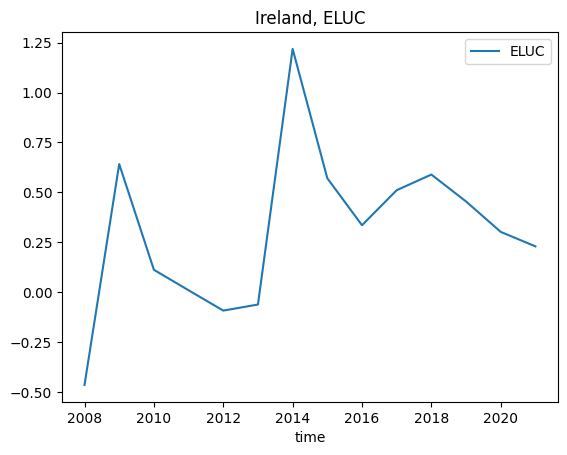

In [27]:
ireland_df[["time", "ELUC"]].plot(x='time', title="Ireland, ELUC")

In [28]:
def land_pie_plot(df, year, point_name):
    features = [a for a in LAND_FEATURES if a not in ['cell_area']]
    df[df.time == year][features].iloc[0].plot.pie(label=f"{point_name}, {year}")

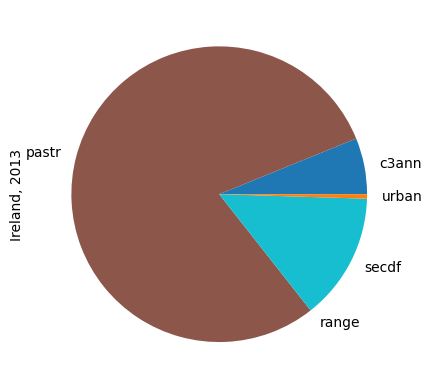

In [29]:
land_pie_plot(ireland_df, 2013, "Ireland")

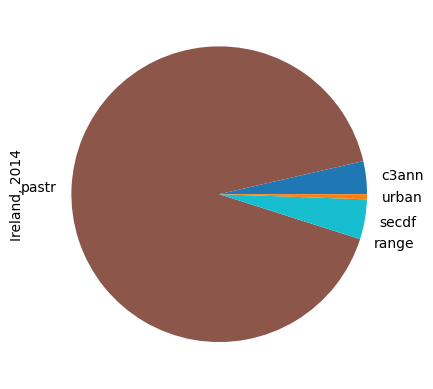

In [30]:
land_pie_plot(ireland_df, 2014, "Ireland")

## Train

In [31]:
%%time
uk_predictor = xgb.XGBRegressor()
uk_predictor.fit(uk_dfs["Train"]["X"][FEATURES], uk_dfs["Train"]["y"][LABEL])

CPU times: user 21.3 s, sys: 5.69 s, total: 27 s
Wall time: 2.94 s


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

## Evaluate

In [32]:
evaluate_predictor(uk_predictor, uk_dfs)

MSE: 0.01680632121860981
RMSE: 0.12963919341564178
MAE: 0.09051559120416641


## Feature importance

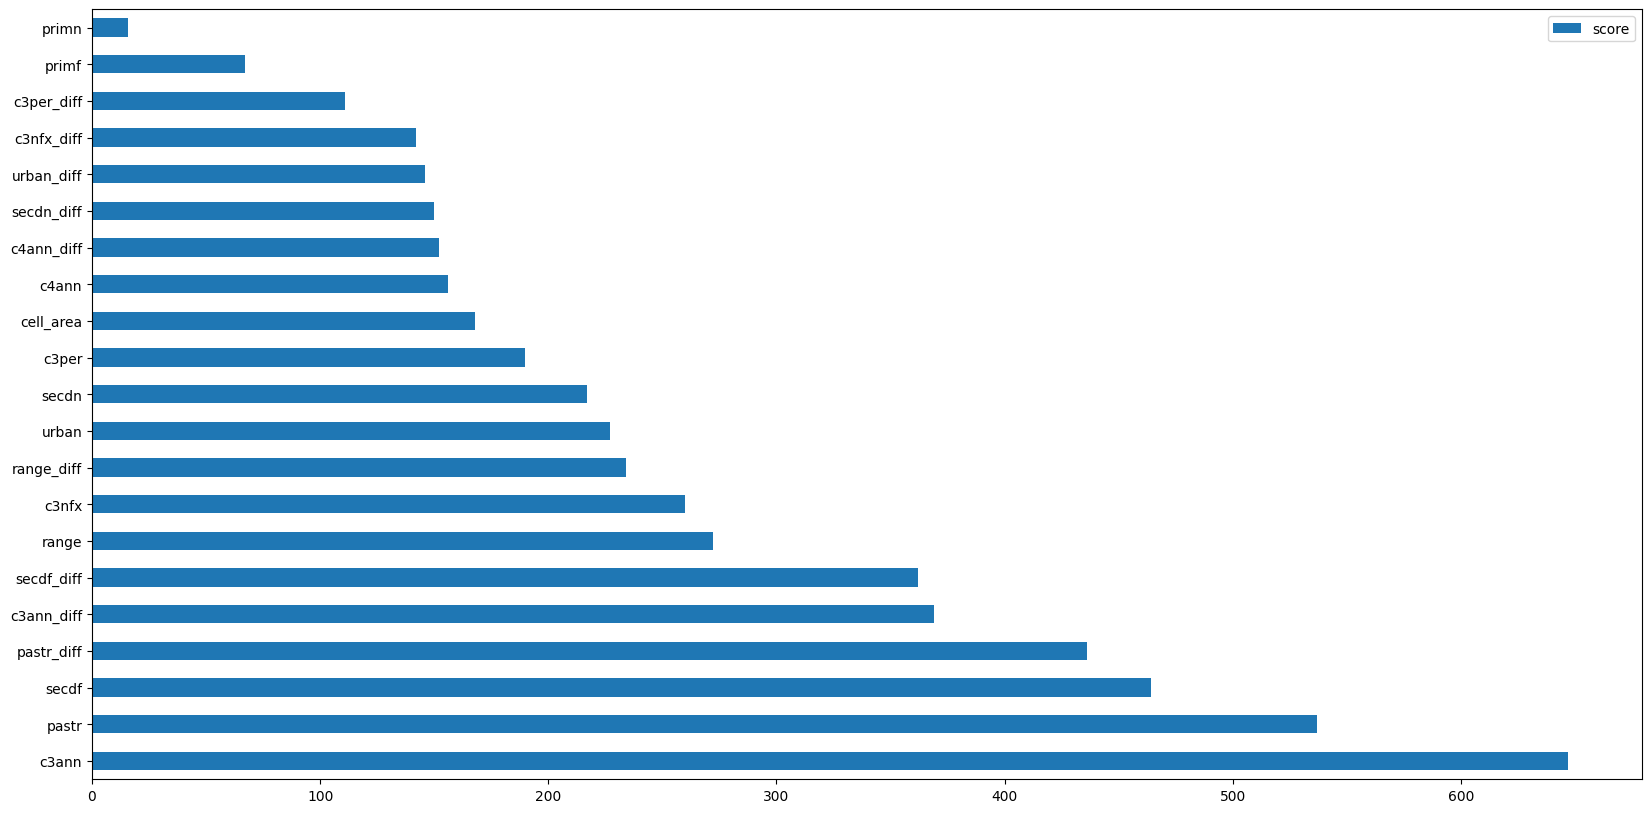

In [33]:
plot_feature_importance(uk_predictor)

## Plot LUC and ELUC

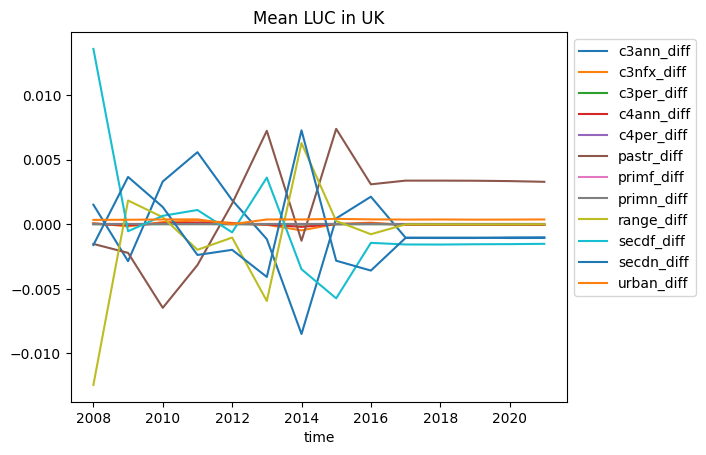

In [34]:
plot_luc(uk_dfs, title="Mean LUC in UK")

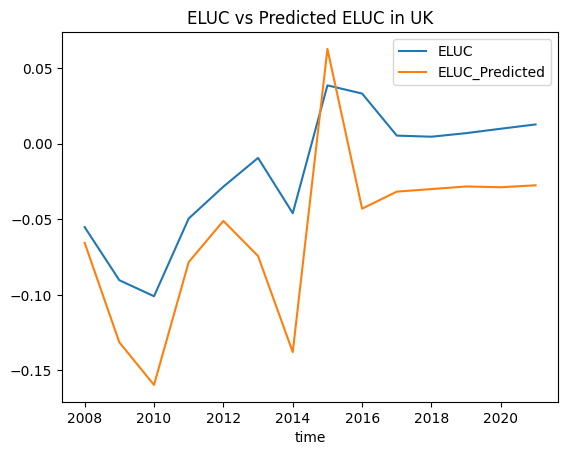

In [35]:
plot_eluc(uk_predictor, uk_dfs, title="ELUC vs Predicted ELUC in UK")

# Brazil
## Train and test sets
Create a dataset for a single country to keep it small and easy to train on  
Country: Brazil  
Train on data between 1850 and 2007  
Test on data after 2007 (i.e. 2008 to 2021)

In [36]:
countries_df[countries_df.names == 'Brazil']

,abbrevs,names
numbers,,
29,BR,Brazil


In [37]:
brazil_dfs = create_country_dataset(ds, [29], 2007)

In [38]:
brazil_dfs["Test"]["y"].head()

,time,i_lat,i_lon,mask,lat,lon,country,ELUC
0,2008,5.125,-60.625,29.0,5.125,-60.625,29.0,-0.051281
1,2008,5.125,-60.375,29.0,5.125,-60.375,29.0,0.018765
2,2008,5.125,-60.125,29.0,5.125,-60.125,29.0,0.018363
3,2008,4.875,-60.625,29.0,4.875,-60.625,29.0,-0.014804
4,2008,4.875,-60.375,29.0,4.875,-60.375,29.0,0.078515


## Train

In [39]:
%%time
brazil_predictor = xgb.XGBRegressor()
brazil_predictor.fit(brazil_dfs["Train"]["X"][FEATURES], brazil_dfs["Train"]["y"][LABEL])

CPU times: user 7min 33s, sys: 31.8 s, total: 8min 4s
Wall time: 56.7 s


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

## Evaluate

In [40]:
evaluate_predictor(brazil_predictor, brazil_dfs)

MSE: 0.18151696026325226
RMSE: 0.42604807019233704
MAE: 0.22048033773899078


## Feature importance

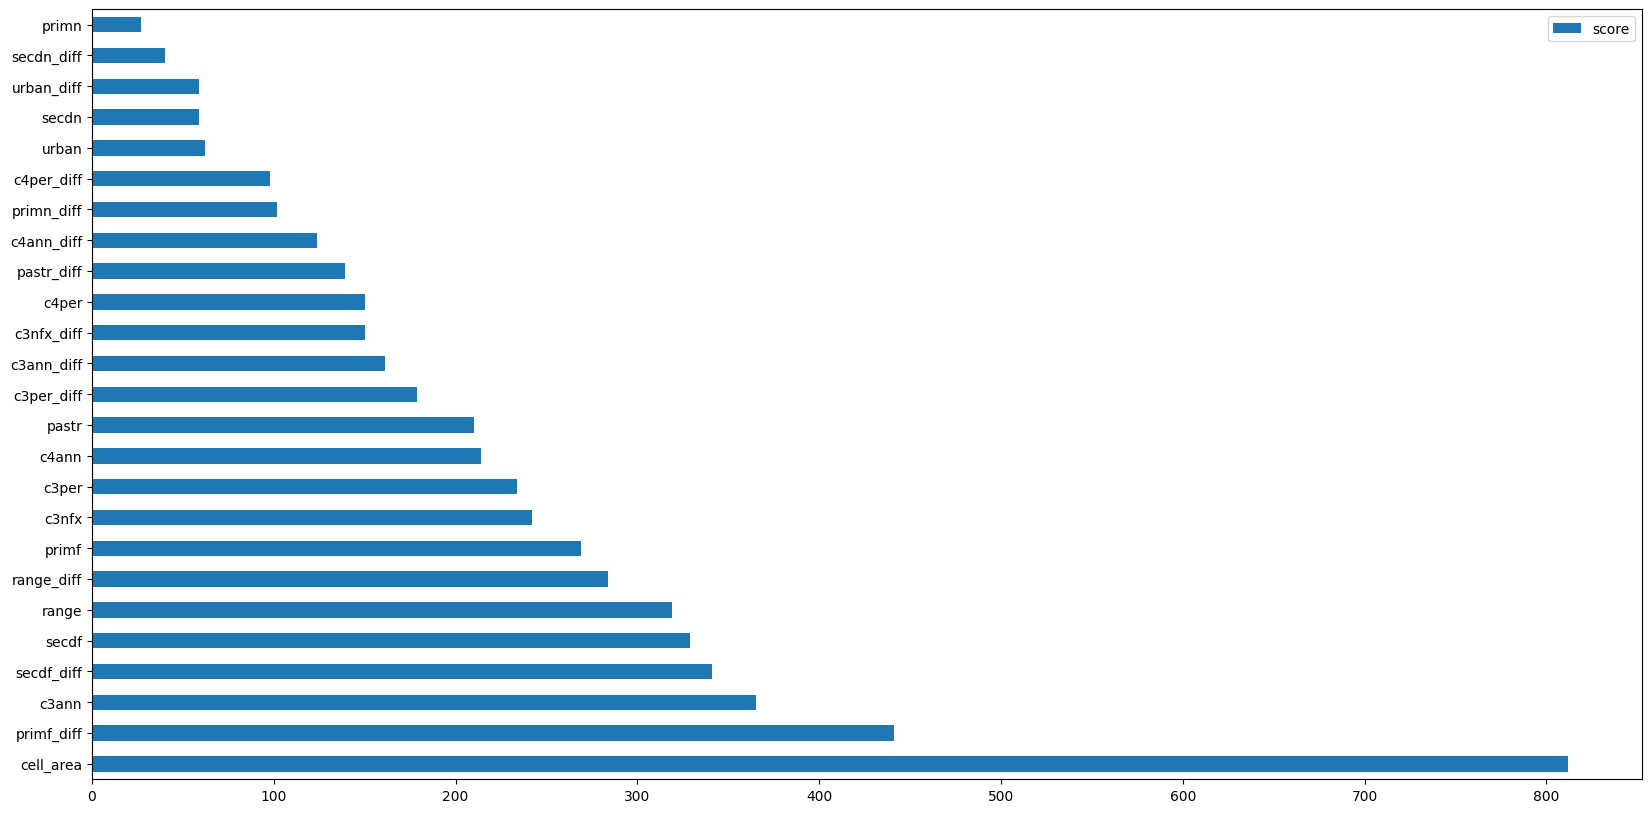

In [41]:
plot_feature_importance(brazil_predictor)

## Plot LUC and ELUC

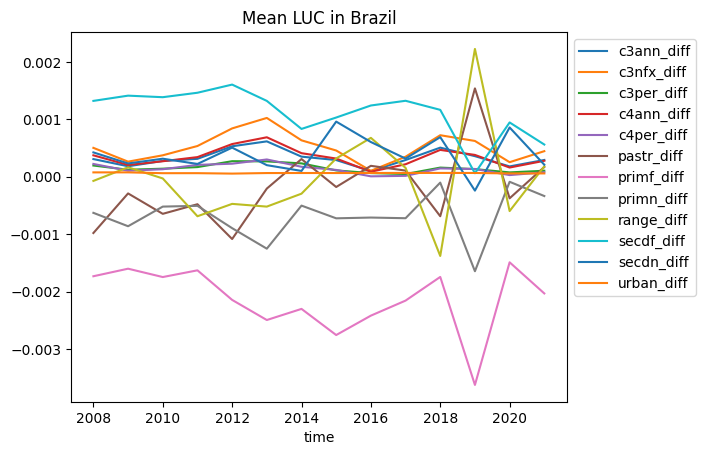

In [42]:
plot_luc(brazil_dfs, title="Mean LUC in Brazil")

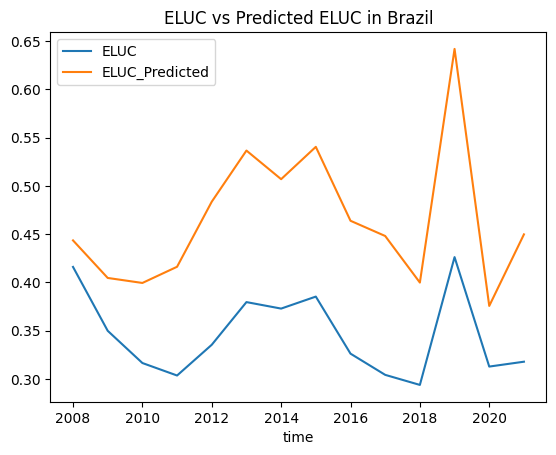

In [43]:
plot_eluc(brazil_predictor, brazil_dfs, title="ELUC vs Predicted ELUC in Brazil")

# Compare country predictors

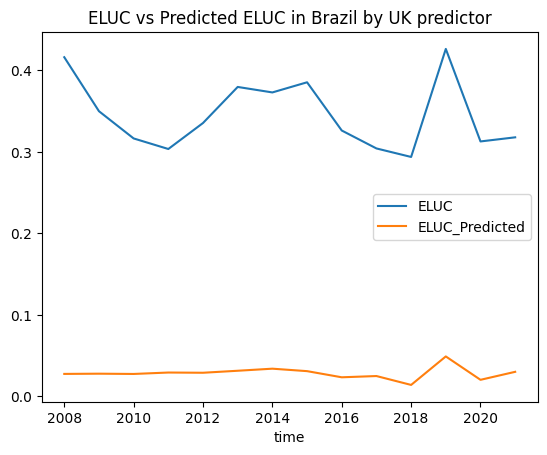

In [44]:
plot_eluc(uk_predictor, brazil_dfs, title="ELUC vs Predicted ELUC in Brazil by UK predictor")

In [ ]:
# UK predictor is pretty bad at predicting ELUC in Brazil

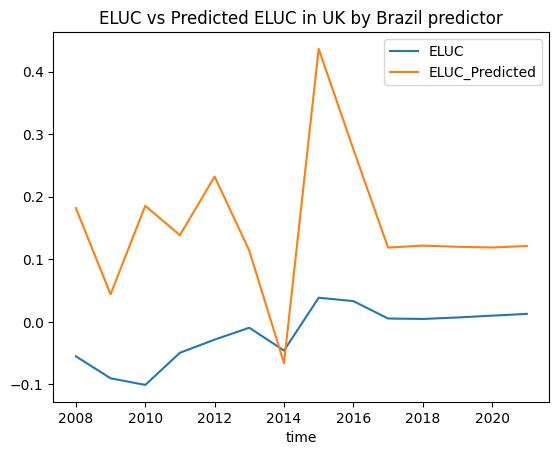

In [45]:
plot_eluc(brazil_predictor, uk_dfs, title="ELUC vs Predicted ELUC in UK by Brazil predictor")

In [ ]:
# Brazil predictor is also pretty bad at predicting ELUC for UK, though a little better

# Brazil & UK

In [54]:
mix_dfs = create_country_dataset(ds, [29, 143], 2007)

In [55]:
mix_dfs["Test"]["y"].head()

,time,i_lat,i_lon,mask,lat,lon,country,ELUC
0,2008,58.625,-3.125,143.0,58.625,-3.125,143.0,-0.011683
1,2008,58.375,-5.125,143.0,58.375,-5.125,143.0,0.056483
2,2008,58.375,-4.875,143.0,58.375,-4.875,143.0,0.089952
3,2008,58.375,-4.625,143.0,58.375,-4.625,143.0,0.158279
4,2008,58.375,-4.375,143.0,58.375,-4.375,143.0,0.085307


## Train

In [57]:
%%time
mix_predictor = xgb.XGBRegressor()
mix_predictor.fit(mix_dfs["Train"]["X"][FEATURES], mix_dfs["Train"]["y"][LABEL])

CPU times: user 8min 6s, sys: 32.6 s, total: 8min 39s
Wall time: 59.1 s


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

## Evaluate

In [60]:
evaluate_predictor(mix_predictor, mix_dfs)

MSE: 0.1875569224357605
RMSE: 0.43307843804359436
MAE: 0.2200574278831482


## Feature importance

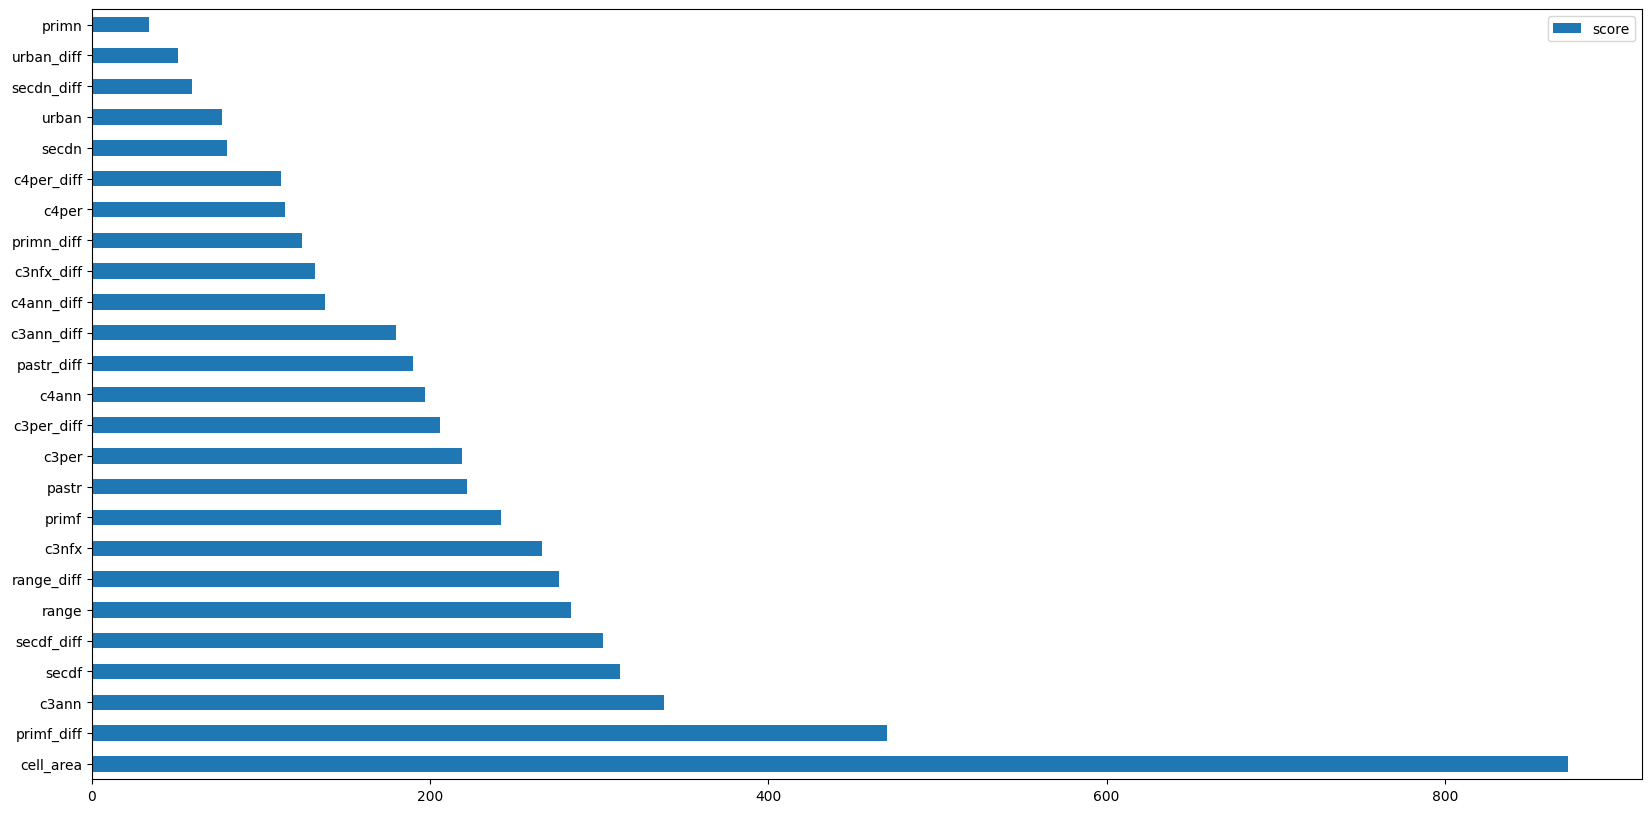

In [61]:
plot_feature_importance(mix_predictor)

## Plot LUC and ELUC

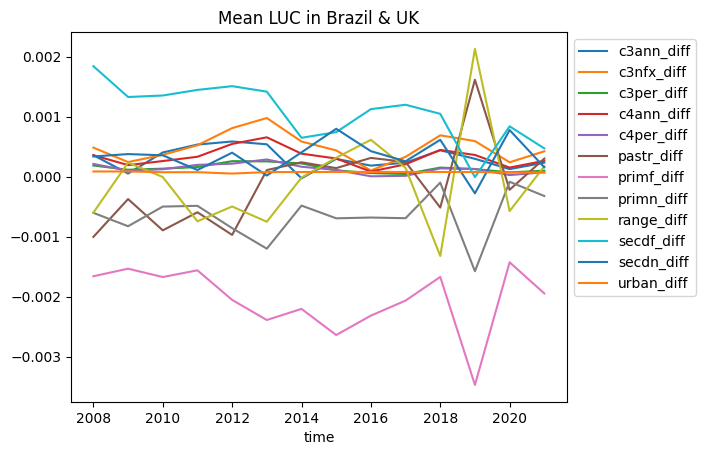

In [62]:
plot_luc(mix_dfs, title="Mean LUC in Brazil & UK")

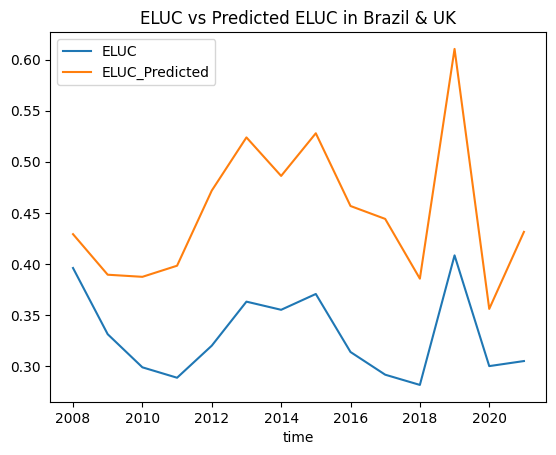

In [63]:
plot_eluc(mix_predictor, mix_dfs, title="ELUC vs Predicted ELUC in Brazil & UK")

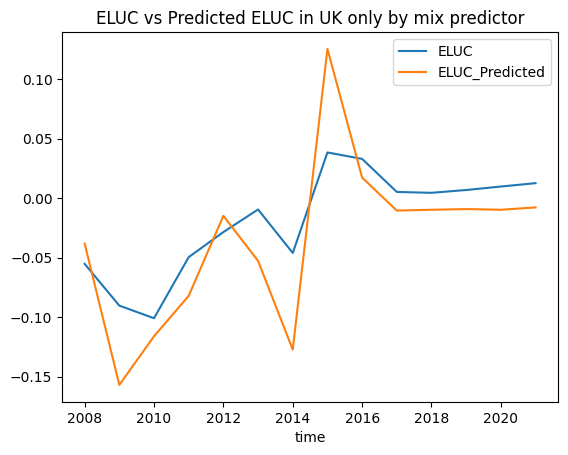

In [64]:
plot_eluc(mix_predictor, uk_dfs, title="ELUC vs Predicted ELUC in UK only by mix predictor")

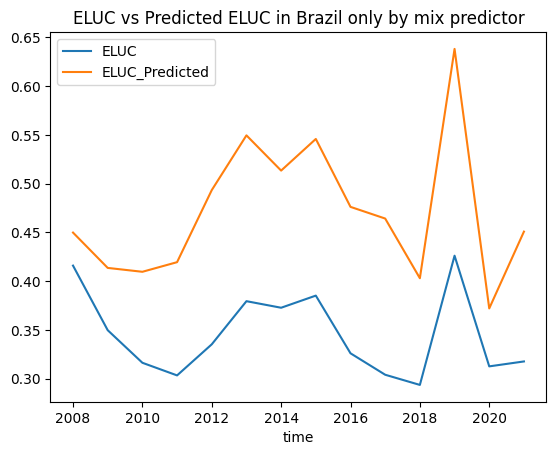

In [65]:
plot_eluc(mix_predictor, brazil_dfs, title="ELUC vs Predicted ELUC in Brazil only by mix predictor")

# XGBoost (xarray)

In [ ]:
# import xgboost as xgb
# from sklearn.metrics import mean_squared_error
# from sklearn.metrics import mean_absolute_error

In [ ]:
# X_train = np.column_stack([X_train[feature].values for feature in features])

In [ ]:
# model = xgb.XGBRegressor()

In [ ]:
# %%time
# model.fit(X_train, y_train)

In [ ]:
# X_test = np.column_stack([X_test[feature].values for feature in features])

In [ ]:
# preds = model.predict(X_test)
# preds

In [ ]:

# mse = mean_squared_error(y_test, preds, squared=True)
# rmse = mean_squared_error(y_test, preds, squared=False)
# mae = mean_absolute_error(y_test, preds)
# print(f"MSE: {mse}")
# print(f"RMSE: {rmse}")
# print(f"MAE: {mae}")

In [ ]:
# preds.shape

# TODO: Single point prediction

In [ ]:
# Max ELUC
y_test_df["ELUC"].max()

In [ ]:
y_test_df[y_test_df["ELUC"] == y_test_df["ELUC"].max()]

In [ ]:
wales_y_df = y_test_df[(y_test_df.i_lat==52.875) & 
                       (y_test_df.i_lon==-4.625)]
wales_y_df

In [ ]:
wales_X_df = X_test_df[(X_test_df.i_lat==52.875) & 
                       (X_test_df.i_lon==-4.625)]
wales_X_df

In [ ]:
wales_X_df[["time"] + LAND_DIFF_FEATURES].plot(x='time')
plt.legend(bbox_to_anchor=(1.0, 1.0))

In [ ]:
wales_y_df[['ELUC', 'time']].plot(x="time", y="ELUC")

In [ ]:
wales_preds = predictor.predict(wales_X_df)

In [ ]:
wales_preds.shape

In [ ]:
wales_y_df["ELUC_Pred"] = wales_preds

In [ ]:
wales_y_df

In [ ]:
wales_y_df.plot(x="time", y=["ELUC", "ELUC_Pred"])